In [113]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Annotated
from langchain_huggingface import HuggingFaceEndpoint,ChatHuggingFace
from langchain_core.messages import BaseMessage , HumanMessage
from dotenv import load_dotenv

from langgraph.checkpoint.memory import MemorySaver


In [114]:
from langgraph.graph.message import add_messages

class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage],add_messages]

In [115]:
load_dotenv()
llm = HuggingFaceEndpoint(
    repo_id='meta-llama/Llama-3.3-70B-Instruct',
    task= 'text-generation'
)
model = ChatHuggingFace(llm=llm)

In [116]:
def chat_model(state: ChatState):

    #take user query from state
    messages = state['messages']

    #send to llm
    response = model.invoke(messages)

    #response store state
    return {'messages':[response]}

In [117]:
checkpointer = MemorySaver()

graph = StateGraph(ChatState)

#add node
graph.add_node('chat_model',chat_model)

graph.add_edge(START,'chat_model')
graph.add_edge('chat_model',END)

chatbot = graph.compile(checkpointer=checkpointer)


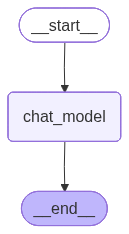

In [118]:
chatbot

In [119]:
# intital_state = {
#     'messages' : [HumanMessage(content='what is the capital of india')]
# }
# chatbot.invoke(intital_state)['messages'][-1].content



In [120]:
thread_id = '1';

while True:
    user_message = input('Type HERE..')

    print('user:',user_message)

    if(user_message.strip().lower() in ['end','quit','bye']):
        print('AI:bye! hope we meet soon')
        break

    config = {'configurable':{'thread_id':thread_id}}

    response = chatbot.invoke({'messages':[HumanMessage(content=user_message)]},config=config)

    print('AI:',response['messages'][-1].content)

user: hi
AI: How can I help you today?
user: my name is shreyank
AI: Nice to meet you, Shreyank! How's your day going so far?
user: tell me my name 
AI: Your name is Shreyank!
user: end
AI:bye! hope we meet soon


In [ ]:
# In this chatbot, there is no concept of memory for previous data. For example,
# if I enter my name, it doesn’t even remember it.

# Basically, when the while loop is running, the chatbot is invoked every time,
# and each time a fresh state is used for the model. 
# That’s why it has no awareness of previous interactions.

# How to solve this:

# To address this issue of memory and maintaining records of previous chats for any chat model,
# we use the concept called “persistence.”

# Every time the while loop runs, our model is invoked and produces output.
# Once we reach the end of the chatbot session,
# the previous state is lost. So, in each iteration, the state starts fresh.
# By implementing persistence,
# we can retain previous chat history and maintain context across multiple interactions.

# The idea of persistence is that when we reach the end,
# we don’t erase the things stored in the state,
# and we save the terms of the previous state somewhere it could be a database or some storage.


# for that use:
# from langgraph.checkpoint.memory import MemorySaver

In [121]:
#to see state for the chat we did
chatbot.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='33e61062-2254-49ab-8324-df7b815366b9'), AIMessage(content='How can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44}, 'model_name': 'meta-llama/Llama-3.3-70B-Instruct', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--45f51bba-e356-4fd1-9c81-2220700c1bda-0', usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44}), HumanMessage(content='my name is shreyank', additional_kwargs={}, response_metadata={}, id='c50bf209-6556-4f47-9c84-55e1d6babb67'), AIMessage(content="Nice to meet you, Shreyank! How's your day going so far?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 59, 'total_tokens': 77}, 'model_name': 'meta-llama/Llama-3.3-70B-Instruct', 'system_fingerprint': None, 'finish_reason':